# Homework 1. Regression

## Importing packages

In [1]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Data Generation 

We use function $f(x) = x^2$ on the interval \[-3, 3). Data samples are generated as follows: $t_i = f(x_i) + \varepsilon_i$, where $\varepsilon \in \mathcal{N}(0, 0.2)$. Size of the data set is 200.

In [2]:
size = 200
mu = 0.0
sigma = 0.2
a = -3
b = 3

In [3]:
noise = np.random.normal(mu, sigma, size)
raw_features = np.random.random_sample((size, )) * (b - a) + np.ones((size, )) * a
labels = np.multiply(raw_features, raw_features) + noise

Let us have a look at the generated data.

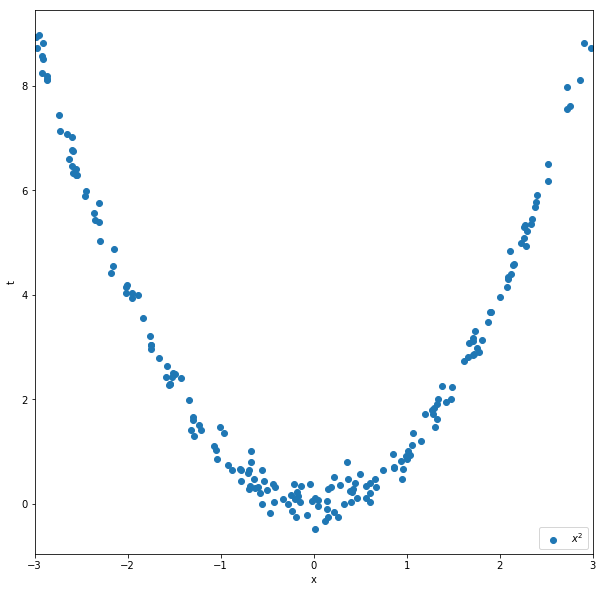

In [4]:
plt.figure(figsize = (10, 10))
plt.scatter(raw_features, labels, label = "$x^2$")
plt.xlim([-3, 3])
plt.legend(loc = "lower right")
plt.xlabel("x")
plt.ylabel("t")
plt.savefig("raw_data.eps")
plt.show()

## Basis functions

As basis functions in this task we use $\sin(kx), \cos(kx)$. We choose 11 basis functions: 

const, $\sin(x), \sin(2x), \sin(3x), \sin(4x), \sin(5x), \cos(x), \cos(2x), \cos(3x), \cos(4x), \cos(5x)$.

Let us calculate new feature matrix.

In [5]:
def new_feature(x):
    features = np.array([1, 
                         math.sin(x), 
                         math.sin(2 * x),
                         math.sin(3 * x),
                         math.sin(4 * x),
                         math.sin(5 * x),
                         math.cos(x), 
                         math.cos(2 * x),
                         math.cos(3 * x),
                         math.cos(4 * x),
                         math.cos(5 * x),])
    return features

In [6]:
def approx_function(w:np.ndarray, x):
    return np.dot(w, new_feature(x))

In [7]:
features = np.array([new_feature(x) for x in raw_features])

The loss function and its gradient:

$$
Q(\{x_i, t_i\}, \overline{w}) = \frac{1}{|Train|}\sum\limits_{i \in Train} (\sum\limits_{j = 1}^{10} w_j \cdot \phi_j(x_i) + w_0 - t_i)^2
$$

$$
\nabla Q(\{x_i, t_i\}, \overline{w}) =  \frac{2}{|Train|}\sum\limits_{i \in Train} \left(\sum\limits_{j = 1}^{10} w_j \cdot \phi_j(x_i) + w_0 - t_i \right) \cdot \begin{bmatrix} 1 \\
                                 \phi_1(x_i) \\
                                 \vdots \\
                                 \phi_{10}(x_i)\\
                 \end{bmatrix}
$$

## Dividing the whole data into training and test parts

In [8]:
indices = np.arange(size)
X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(features, labels, indices, test_size=0.2)

## Finding optimal w

### Batch gradient descent

Let zero vector of size 11 be an initial estimation of the vector w. We launch 600 iteratios of batch gradient descent, stepsize is 0.01.

In [9]:
w_bgd = np.zeros(11)
stepsize = 0.01
max_iter = 600
loss_history = np.zeros((max_iter, ))

In [10]:
def loss_function(features:np.ndarray, labels:np.ndarray, w:np.ndarray):
    N = len(labels)
    return np.sum(np.multiply((np.dot(features, w) - labels), (np.dot(features, w) - labels))) / N

In [11]:
def loss_grad(features:np.ndarray, labels:np.ndarray, w:np.ndarray):
    N = len(labels)
    return (2 / N) * np.dot(np.transpose(features), np.dot(features, w) - labels)

In [12]:
for i in range(max_iter):
    loss_history[i] = loss_function(X_train, Y_train, w_bgd)
    w_bgd -= stepsize * loss_grad(X_train, Y_train, w_bgd)

Error function decreases in the following way:

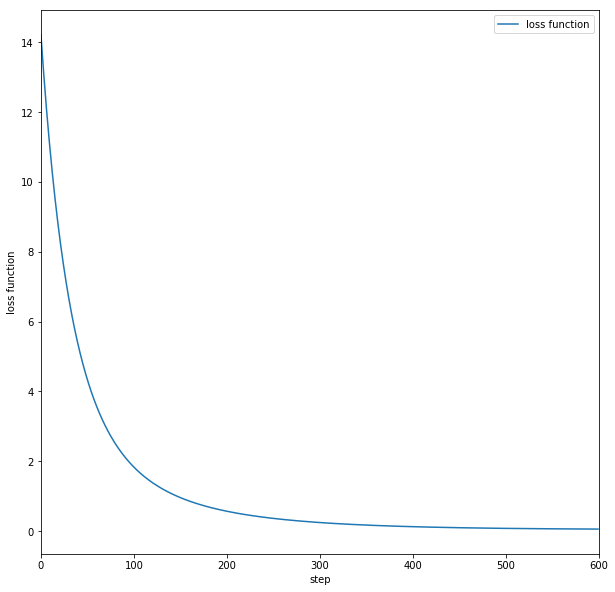

In [13]:
plt.figure(figsize = (10, 10))
plt.plot(range(0, max_iter), loss_history, label = "loss function")
plt.xlim([0, max_iter])
plt.legend(loc = "upper right")
plt.xlabel("step")
plt.ylabel("loss function")
plt.savefig("bgd.eps")
plt.show()

The resulting vector $w$:

In [14]:
w_bgd

array([ 3.24564048, -0.02612761,  0.02451596, -0.03073927,  0.03461865,
       -0.02345948, -3.85361018,  0.83517901, -0.30837982,  0.17438777,
       -0.09655867])

Let us look at the learned regression function on the test set and compare it with actuual targets:

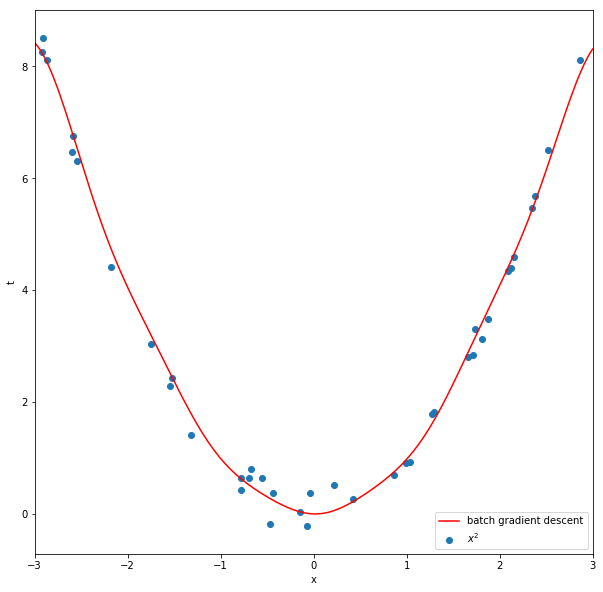

In [15]:
x_fig_bgd = np.linspace(-3, 3, 200)
y_fig_bgd = [approx_function(w_bgd, point) for point in x_fig_bgd]

plt.figure(figsize = (10, 10))
plt.plot(x_fig_bgd, y_fig_bgd, label = "batch gradient descent", color = 'r')
plt.scatter(raw_features[idx_test], Y_test, label = "$x^2$")
plt.xlim([-3, 3])
plt.legend(loc = "lower right")
plt.xlabel("x")
plt.ylabel("t")
plt.savefig("bgd_final.eps")
plt.show()

Let us calculate root mean square error.

In [16]:
def RMSE(X_test, Y_test, w):
    return np.sqrt(np.sum(np.multiply(np.dot(X_test, w) - Y_test, np.dot(X_test, w) - Y_test)) / len(Y_test))

In [17]:
RMSE_bgd = RMSE(X_test, Y_test, w_bgd)
RMSE_bgd

0.2181727161070104

### Stochastic gradient descent

Settings are the same as in the previous case, but now we use stochastic gradient descent. Stepsizes decreases as $\frac{1}{k}$.

In [18]:
w_sgd = np.zeros(11)
max_iter = 600
loss_history_sgd = np.zeros((max_iter, ))

In [19]:
np.random.seed(100)
for i in range(max_iter):
    loss_history_sgd[i] = loss_function(X_train, Y_train, w_sgd)
    index = np.random.randint(0, len(Y_train))
    w_sgd -= 2/(i+1) * (np.dot(X_train[index], w_sgd) - Y_train[index]) * X_train[index]

Error function decreases in the following way:

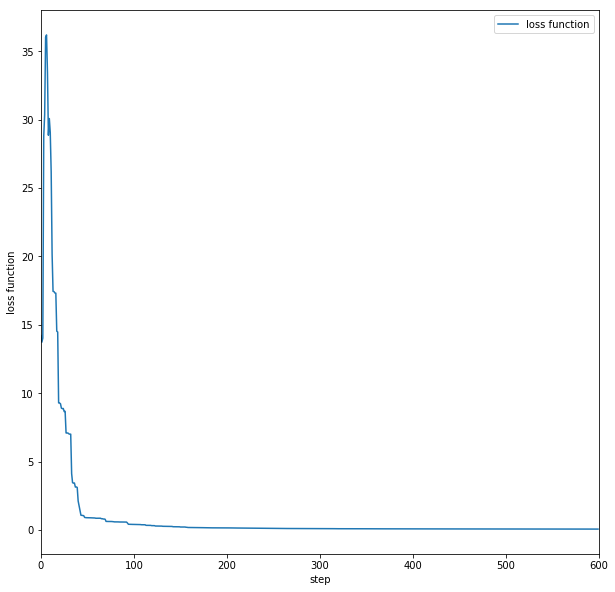

In [20]:
plt.figure(figsize = (10, 10))
plt.plot(range(0, max_iter), loss_history_sgd, label = "loss function")
plt.xlim([0, max_iter])
plt.legend(loc = "upper right")
plt.xlabel("step")
plt.ylabel("loss function")
plt.savefig("sgd.eps")
plt.show()

The resulting vector $w$:

In [21]:
w_sgd

array([ 3.27856620e+00, -9.28912650e-02,  9.30951751e-02, -1.54345856e-03,
       -4.30283265e-02,  2.10181124e-02, -3.92984530e+00,  8.91888448e-01,
       -2.68399309e-01,  1.43010349e-01, -1.30200598e-01])

Let us look at the learned regression function on the test set and compare it with actuual targets:

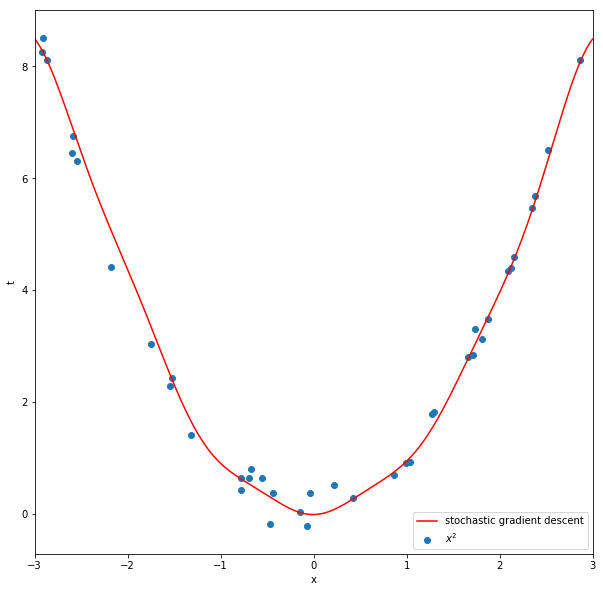

In [22]:
x_fig_sgd = np.linspace(-3, 3, 200)
y_fig_sgd = [approx_function(w_sgd, point) for point in x_fig_sgd]

plt.figure(figsize = (10, 10))
plt.plot(x_fig_sgd, y_fig_sgd, label = "stochastic gradient descent", color = 'r')
plt.scatter(raw_features[idx_test], Y_test, label = "$x^2$")
plt.xlim([-3, 3])
plt.legend(loc = "lower right")
plt.xlabel("x")
plt.ylabel("t")
plt.savefig("sgd_final.eps")
plt.show()

It left to determine RMSE:

In [28]:
RMSE_sgd = RMSE(X_test, Y_test, w_sgd)
RMSE_sgd

0.23293764282427434

### Maximum likelihood

Let us assume that the likelihood is described by Gaussian distribution with zero mean and the standard deviation $\alpha$. Then 

$$
likelihood = \prod\limits_{i \in Train} \frac{1}{\sqrt{2 \pi} \alpha} \exp\{-\frac{\left(\sum\limits_{j = 1}^{10} w_j \cdot \phi_j(x_i) + w_0 - t_i \right)^2}{2\alpha}\} \sim \exp\{ -\frac{\sum\limits_{i \in Train}\left(\sum\limits_{j = 1}^{10} w_j \cdot \phi_j(x_i) + w_0 - t_i \right)^2}{2\alpha} \}
$$

Maximization of likelihood is equivalent to minimization of 

$$
\sum\limits_{i \in Train}\left(\sum\limits_{j = 1}^{10} w_j \cdot \phi_j(x_i) + w_0 - t_i \right)^2 \rightarrow min
$$

Since function of $w$ is convex and differentiable, enforcing the gradient to be equal to zero is sufficient to find the optimal value of $w$. Thus, we get

$$
w_{opt} = \left( \sum\limits_{i \in Train} \boldsymbol{\phi}(x_i) \boldsymbol{\phi}(x_i)^\intercal \right)^\dagger \left(\sum\limits_{i \in Train} t_i \boldsymbol{\phi}(x_i) \right),
$$

where $\boldsymbol{\phi} (x) \in \mathbb{R}^{11}$ denotes the vector of generated features $[1, \phi_1(x), \dots, \phi_{10}(x)]$.

Let us find the optimal $w$ using the formula above.

In [24]:
w_lkl = np.dot(np.linalg.inv(np.dot(np.transpose(X_train), X_train)), np.dot(np.transpose(X_train), Y_train))
w_lkl

array([ 3.29966369e+00,  2.93446271e-03, -3.03183472e-02,  4.06789780e-02,
       -4.49844945e-02,  4.12918069e-02, -3.99536253e+00,  9.58394231e-01,
       -3.96537304e-01,  2.37453817e-01, -1.28951605e-01])

In [25]:
norm_bgd_lkl = np.linalg.norm(w_lkl-w_bgd, 2)
norm_sgd_lkl = np.linalg.norm(w_lkl-w_sgd, 2)
print("Vector norm between ws obtained from batch gradient descent and obtained from maximum likelihood", norm_bgd_lkl)
print("Vector norm between ws obtained from stoch. gradient descent and obtained from maximum likelihood", norm_sgd_lkl)

Vector norm between ws obtained from batch gradient descent and obtained from maximum likelihood 0.2654693137662014
Vector norm between ws obtained from stoch. gradient descent and obtained from maximum likelihood 0.24720872700855942


Let us compare the learned linear regression and actual test data.

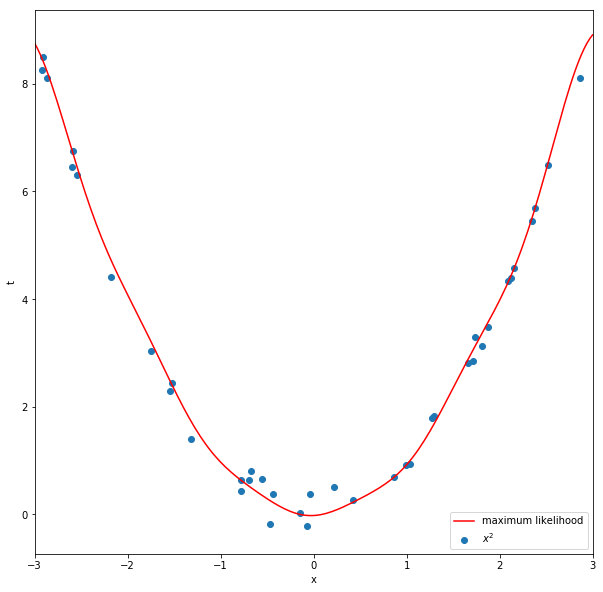

In [26]:
x_fig_lkl = np.linspace(-3, 3, 200)
y_fig_lkl = [approx_function(w_lkl, point) for point in x_fig_lkl]

plt.figure(figsize = (10, 10))
plt.plot(x_fig_lkl, y_fig_lkl, label = "maximum likelihood", color = 'r')
plt.scatter(raw_features[idx_test], Y_test, label = "$x^2$")
plt.xlim([-3, 3])
plt.legend(loc = "lower right")
plt.xlabel("x")
plt.ylabel("t")
plt.savefig("lkl_final.eps")
plt.show()

RMSE has the following value:

In [27]:
RMSE_lkl = RMSE(X_test, Y_test, w_lkl)
RMSE_lkl

0.20314564595055676

In this work it appeared to be that the maximum lilelihood approach has the best performance in terms of RMSE on the test data. But, generally speaking, all three approaches solve the same problem of minimizing the squared error of the train data and the maximum likelihood approach solves the problem precisely.